In [35]:
#
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import sklearn.metrics as sk_metrics
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import datasets
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
from PIL import Image
tfd = tfp.distributions
tfpl = tfp.layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

aug = iaa.imgcorruptlike.ImpulseNoise(severity=3)

x_c_train = []; y_c_train = y_train.copy(); x_c_test = []; y_c_test = y_test.copy()
print(x_train.shape); print(y_train.shape); print(x_test.shape); print(y_test.shape); 

fig_N = 3; imgW = 28
conversion_ctl = 0 
draw_original = 1; draw_aug = 1
gen_deterministic_model = 1; eval_deterministic_model = 1
gen_prob_model = 1; eval_prob_model = 1

(60000, 28, 28)
(60000, 10)
(10000, 28, 28)
(10000, 10)


In [36]:
def corrupt_image(src):
    img = Image.fromarray(src) 
    img_resized = img.resize((imgW*2,imgW*2))
    img_arr = np.array(img_resized)
    img_aug = aug(image=img_arr) 
    img = Image.fromarray(img_aug)    
    img_resized = img.resize((imgW,imgW))
    return np.array(img_resized)

def run_conversion():
    print("Start conversion..")
    len_conversion = x_train.shape[0]; kind = "x_train"; d = int(len_conversion/10)
    for i in range(len_conversion):
     x_c_train.append(corrupt_image(x_train[i]))
     if (i % d == 0):
      print("Running conversion {}, percent: {}%".format(kind, i/len_conversion*100))
    len_conversion = x_test.shape[0]; kind = "x_test"; d = int(len_conversion/10)
    for i in range(len_conversion):
     x_c_test.append(corrupt_image(x_test[i]))
     if (i % d == 0):
      print("Running conversion {}, percent: {}%".format(kind, i/len_conversion*100))
    np.savez("x_c_train.npz", arr=x_c_train) # save all in one file
    np.savez("x_c_test.npz", arr=x_c_test) # save all in one file
    print("End conversion")

In [37]:
def nll(y_true, y_pred):
    """
    This function should return the negative log-likelihood of each sample
    in y_true given the predicted distribution y_pred. If y_true is of shape
    [B, E] and y_pred has batch shape [B] and event_shape [E], the output
    should be a Tensor of shape [B].
    """
    return -y_pred.log_prob(y_true)  

def get_deterministic_model(input_shape, loss, optimizer, metrics):
    model = keras.Sequential([
        layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu', padding='valid', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(6, 6)),
        layers.Flatten(),
        layers.Dense(units=10, activation='softmax')
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
    
def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    """
    This function should return the probabilistic model according to the
    above specification.
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    model = keras.Sequential([
        layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu', padding='valid', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(6, 6)),
        layers.Flatten(),
        layers.Dense(tfpl.OneHotCategorical.params_size(10)),
        tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [38]:
if conversion_ctl == 1:
    run_conversion()
else:
    x_c_train = np.load("x_c_train.npz")['arr'] 
    x_c_test = np.load("x_c_test.npz")['arr'] 
    print("Data loaded from npz files.")

x_train = 1.0-x_train.astype("float32") / 255.0
x_test = 1.0-x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_c_train = 1.0-x_c_train.astype("float32") / 255.0
x_c_test = 1.0-x_c_test.astype("float32") / 255.0
x_c_train = np.expand_dims(x_c_train, -1)
x_c_test = np.expand_dims(x_c_test, -1)


Data loaded from npz files.


Original



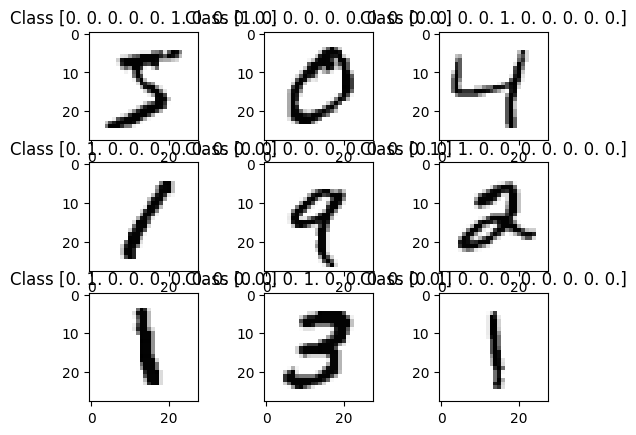

In [39]:
if draw_original == 1:
    print("Original");
    for i in range(fig_N*fig_N):
     plt.subplot(fig_N,fig_N,i+1)
     plt.imshow(x_train[i], cmap='gray', interpolation='none')
     plt.title("Class {}".format(y_train[i]))
    print("");

Augmented



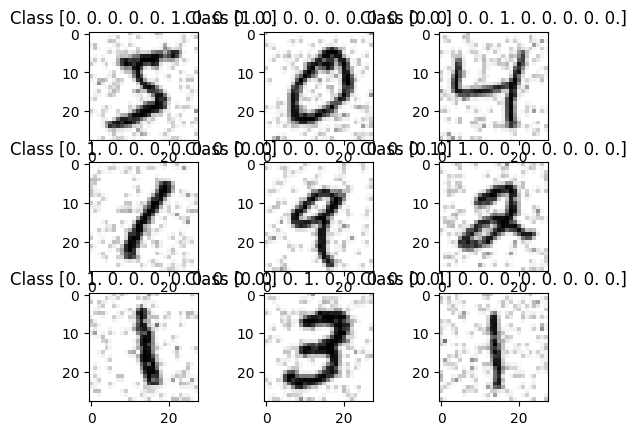

In [40]:
if draw_aug == 1:
    print("Augmented");
    for i in range(fig_N*fig_N):
     plt.subplot(fig_N,fig_N,i+1)
     plt.imshow(x_c_train[i], cmap='gray', interpolation='none')
     plt.title("Class {}".format(y_train[i]))
    print("");


In [41]:
if gen_deterministic_model == 1:
    tf.random.set_seed(0)
    deterministic_model = get_deterministic_model(
        input_shape=(28, 28, 1),
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    deterministic_model.summary()
    deterministic_model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)
    deterministic_model.save('deterministic_mnist.keras')  
else:
    deterministic_model = tf.keras.models.load_model('deterministic_mnist.keras')
    
if eval_deterministic_model == 1:
    print('Accuracy on MNIST test set: ',
          str(deterministic_model.evaluate(x_test, y_test, verbose=False)[1]))
    print('Accuracy on corrupted MNIST test set: ',
          str(deterministic_model.evaluate(x_c_test, y_c_test, verbose=False)[1]))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 8)           0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1498 (5.85 KB)
Trainable params: 1498 (5.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
422/422 [==============================] - 4s 8ms/step - loss: 1.0566 - accura

In [42]:
if gen_prob_model == 1:
    tf.random.set_seed(0)
    probabilistic_model = get_probabilistic_model(
        input_shape=(28, 28, 1),
        loss=nll,
        optimizer="adam",
        metrics=["accuracy"]
    )
    probabilistic_model.summary()    
    probabilistic_model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)
    probabilistic_model.save('prob_mnist.keras')  
else:
    probabilistic_model = tf.keras.models.load_model('prob_mnist.keras')
    
if eval_prob_model == 1:
    print('Accuracy on MNIST test set (prob): ',
          str(probabilistic_model.evaluate(x_test, y_test, verbose=False)[1]))
    print('Accuracy on corrupted MNIST test set (prob): ',
          str(probabilistic_model.evaluate(x_c_test, y_c_test, verbose=False)[1]))


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 8)           0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
 one_hot_categorical_1 (One  ((None, 10),              0         
 HotCategorical)              (None, 10))                        
                                                                 
Total params: 1498 (5.85 KB)
Trainable params: 1498 (5